In [ ]:
#import VOC tensorflow dataset as an example

In [54]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import *

ds_train, ds_info = tfds.load('voc', split='train', with_info=True)

In [55]:
ds_info

tfds.core.DatasetInfo(
    name='voc',
    version=4.0.0,
    description='This dataset contains the data from the PASCAL Visual Object Classes Challenge
2007, a.k.a. VOC2007, corresponding to the Classification and Detection
competitions.
A total of 9963 images are included in this dataset, where each image
contains a set of objects, out of 20 different classes, making a total of
24640 annotated objects.
In the Classification competition, the goal is to predict the set of labels
contained in the image, while in the Detection competition the goal is to
predict the bounding box and label of each individual object.
annotations.',
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'labels': Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20)),
        'labels_no_difficult': Sequence(ClassLabel(shape=(), dtype=t

In [78]:
def draw_boxes(data, v_boxes):
    pyplot.imshow(data)
    ax = pyplot.gca()
    h = tf.dtypes.cast(tf.shape(img)[1], tf.float32)
    w = tf.dtypes.cast(tf.shape(img)[0], tf.float32)
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box[0]*w, box[1]*h, box[2]*w, box[3]*h
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
    pyplot.show()

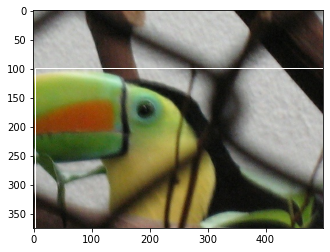

In [81]:
voc_iter = iter(ds_train)
val = next(voc_iter)
val = next(voc_iter)
val = next(voc_iter)
img = val['image']
img_label = val['labels']
img_info = val['objects']
box = img_info.get('bbox')
draw_boxes(img, box)

In [ ]:
# common
class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True, activate_type='leaky'):
    if downsample:
        input_layer = tf.keras.layers.ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'
    conv = tf.keras.layers.Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides, padding=padding,
                                  use_bias=not bn, kernel_regularizer=tf.keras.regularizers.l2(0.0005),
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                  bias_initializer=tf.constant_initializer(0.))(input_layer)

    if bn: conv = BatchNormalization()(conv)
    if activate == True:
        if activate_type == "leaky":
            conv = tf.nn.leaky_relu(conv, alpha=0.1)
        elif activate_type == "mish":
            conv = mish(conv)
    return conv

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

def residual_block(input_layer, input_channel, filter_num1, filter_num2, activate_type='leaky'):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1), activate_type=activate_type)
    conv = convolutional(conv, filters_shape=(3, 3, filter_num1,   filter_num2), activate_type=activate_type)
    residual_output = short_cut + conv
    return residual_output

def route_group(input_layer, groups, group_id):
    convs = tf.split(input_layer, num_or_size_splits=groups, axis=-1)
    return convs[group_id]

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='bilinear')

In [4]:
# CSPdarknet53 as backbone
def cspdarknet53(x):
    x = convolutional(x, (3, 3,  3,  32), activate_type="mish")
    x = convolutional(x, (3, 3, 32,  64), downsample=True, activate_type="mish")

    route = x
    route = convolutional(route, (1, 1, 64, 64), activate_type="mish")
    x = convolutional(x, (1, 1, 64, 64), activate_type="mish")
    x = residual_block(x,  64,  32, 64, activate_type="mish")
    x = convolutional(x, (1, 1, 64, 64), activate_type="mish")

    x = tf.concat([x, route], axis=-1)
    x = convolutional(x, (1, 1, 128, 64), activate_type="mish")
    x = convolutional(x, (3, 3, 64, 128), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 128, 64), activate_type="mish")
    x = convolutional(x, (1, 1, 128, 64), activate_type="mish")
    for i in range(2):
        x = residual_block(x, 64,  64, 64, activate_type="mish")
    x = convolutional(x, (1, 1, 64, 64), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 128, 128), activate_type="mish")
    x = convolutional(x, (3, 3, 128, 256), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 256, 128), activate_type="mish")
    x = convolutional(x, (1, 1, 256, 128), activate_type="mish")
    for i in range(8):
        x = residual_block(x, 128, 128, 128, activate_type="mish")
    x = convolutional(x, (1, 1, 128, 128), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 256, 256), activate_type="mish")
    route_1 = x
    x = convolutional(x, (3, 3, 256, 512), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 512, 256), activate_type="mish")
    x = convolutional(x, (1, 1, 512, 256), activate_type="mish")
    for i in range(8):
        x = residual_block(x, 256, 256, 256, activate_type="mish")
    x = convolutional(x, (1, 1, 256, 256), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 512, 512), activate_type="mish")
    route_2 = x
    x = convolutional(x, (3, 3, 512, 1024), downsample=True, activate_type="mish")
    route = x
    route = convolutional(route, (1, 1, 1024, 512), activate_type="mish")
    x = convolutional(x, (1, 1, 1024, 512), activate_type="mish")
    for i in range(4):
        x = residual_block(x, 512, 512, 512, activate_type="mish")
    x = convolutional(x, (1, 1, 512, 512), activate_type="mish")
    x = tf.concat([x, route], axis=-1)

    x = convolutional(x, (1, 1, 1024, 1024), activate_type="mish")
    x = convolutional(x, (1, 1, 1024, 512))
    x = convolutional(x, (3, 3, 512, 1024))
    x = convolutional(x, (1, 1, 1024, 512))

    x = tf.concat([tf.nn.max_pool(x, ksize=13, padding='SAME', strides=1), tf.nn.max_pool(x, ksize=9, padding='SAME', strides=1)
                            , tf.nn.max_pool(x, ksize=5, padding='SAME', strides=1), x], axis=-1)
    x = convolutional(x, (1, 1, 2048, 512))
    x = convolutional(x, (3, 3, 512, 1024))
    x = convolutional(x, (1, 1, 1024, 512))

    return route_1, route_2, x

In [6]:
def YOLOv4(input_layer, NUM_CLASS):
    route_1, route_2, conv = cspdarknet53(input_layer)

    route = conv
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = upsample(conv)
    route_2 = convolutional(route_2, (1, 1, 512, 256))
    conv = tf.concat([route_2, conv], axis=-1)

    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)
    route_1 = convolutional(route_1, (1, 1, 256, 128))
    conv = tf.concat([route_1, conv], axis=-1)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))

    route_1 = conv
    conv = convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = convolutional(conv, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(route_1, (3, 3, 128, 256), downsample=True)
    conv = tf.concat([conv, route_2], axis=-1)

    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = convolutional(conv, (1, 1, 512, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(route_2, (3, 3, 256, 512), downsample=True)
    conv = tf.concat([conv, route], axis=-1)

    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))

    conv = convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = convolutional(conv, (1, 1, 1024, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]